In [1]:
import os
import sys
spark_name = os.environ.get('SPARK_HOME',None)
if not spark_name:
    raise ValueError('SPARK_HOME not set')
sys.path.insert(0,os.path.join(spark_name,'python'))
sys.path.insert(0,os.path.join(spark_name,'python/lib/py4j-0.10.7-src.zip'))
exec(open(os.path.join(spark_name,'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.5.0
      /_/

Using Python version 3.11.4 (main, Jul  5 2023 13:38:37)
Spark context Web UI available at http://DESKTOP-9DRB05G:4040
Spark context available as 'sc' (master = local[*], app id = local-1695891335654).
SparkSession available as 'spark'.


#测试pyspark是否可以使用#

In [2]:
import findspark
findspark.init()
from pyspark import SparkContext
sc.stop()
sc = SparkContext("local", "count app")
words = sc.parallelize(
    ["scala",
     "java",
     "hadoop",
     "spark",
     "akka",
     "spark vs hadoop",
     "pyspark",
     "pyspark and spark"
     ])
counts = words.count()
print("Number of elements in RDD -> %i" % counts)


Number of elements in RDD -> 8


#从HDFS中读取数据#

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv('Uber/uber-raw-data-sep14.csv',header=True)
print(df)

DataFrame[Date/Time: string, Lat: string, Lon: string, Base: string]


#对网约车出行的时间分布进行分析#

In [4]:
from pyspark.sql.functions import to_date, to_timestamp
dateDF = df.select(to_timestamp(df['Date/Time'], 
                                   'MM/dd/yyyy HH:mm:ss').alias('date'))


解析日期时收到如下异常：
You can set \"spark.sql.legacy.timeParserPolicy\" to \"LEGACY\" to restore the behavior before Spark 3.0, or set to \"CORRECTED\" and treat it as an invalid datetime string.\r\n\tat org.apache.spark.sql.errors.
发现下面一行代码可以解决问题

In [5]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [6]:
dateDF.show()

+-------------------+
|               date|
+-------------------+
|2014-09-01 00:01:00|
|2014-09-01 00:01:00|
|2014-09-01 00:03:00|
|2014-09-01 00:06:00|
|2014-09-01 00:11:00|
|2014-09-01 00:12:00|
|2014-09-01 00:15:00|
|2014-09-01 00:16:00|
|2014-09-01 00:32:00|
|2014-09-01 00:33:00|
|2014-09-01 00:33:00|
|2014-09-01 00:37:00|
|2014-09-01 00:38:00|
|2014-09-01 00:39:00|
|2014-09-01 00:48:00|
|2014-09-01 00:48:00|
|2014-09-01 00:49:00|
|2014-09-01 01:08:00|
|2014-09-01 01:17:00|
|2014-09-01 01:19:00|
+-------------------+
only showing top 20 rows



#统计一月内的分布#
利用SQL中GroupBy和count进行按月统计

In [7]:
from pyspark.sql.functions import year,month,dayofmonth
stats_d = dateDF.select(
    dayofmonth('date').alias('day')
).groupBy('day').count().sort('day').collect()

print(stats_d)

[Row(day=1, count=19961), Row(day=2, count=28831), Row(day=3, count=32631), Row(day=4, count=38360), Row(day=5, count=42319), Row(day=6, count=40520), Row(day=7, count=30134), Row(day=8, count=30360), Row(day=9, count=34560), Row(day=10, count=35910), Row(day=11, count=36439), Row(day=12, count=39540), Row(day=13, count=43205), Row(day=14, count=28122), Row(day=15, count=29454), Row(day=16, count=36092), Row(day=17, count=35531), Row(day=18, count=40274), Row(day=19, count=41017), Row(day=20, count=38864), Row(day=21, count=28620), Row(day=22, count=28312), Row(day=23, count=30316), Row(day=24, count=31301), Row(day=25, count=38203), Row(day=26, count=37504), Row(day=27, count=39468), Row(day=28, count=29656), Row(day=29, count=29201), Row(day=30, count=33431)]


#使用matplotlib绘制柱状图#

In [10]:
pip install numpy

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy

In [2]:
import matplotlib.pyplot as plt

ImportError: DLL load failed while importing _path: 找不到指定的模块。

In [3]:
import numpy

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18,16), dpi=80)
plt.subplot(1,1,1)
plt.grid(axis="y", linestyle='--')
width= 0.7

N = len(stats_d)
values = [d['count'] for d in stats_d]
index = np.arange(1,N+1)

p2 = plt.bar(index, values, width, color="#87CEFA")

plt.xlabel('Day')
plt.ylabel('Total Journeys')
plt.title('Journeys by Month Day')

plt.xticks(index)
plt.yticks(np.arange(0,50000,5000))

plt.show()

ImportError: DLL load failed while importing _path: 找不到指定的模块。

#一周内的分布#

In [6]:
from pyspark.sql.functions import dayofweek
stats_w = dateDF.select(
    dayofweek('date').alias('weekday')
).groupBy('weekday').count().sort('weekday').collect()

print(stats_w)

ModuleNotFoundError: No module named 'pyspark'

In [7]:
plt.figure(figsize=(13,11), dpi=80)
plt.subplot(1,1,1)
plt.grid(axis="y", linestyle='--')
width = 0.7

N = len(stats_w)
values = [d['count'] for d in stats_w]
index = np.arange(N)

p2 = plt.bar(index, values, width, color="#87CEFA")

plt.xlabel('Days of Week')
plt.ylabel('Total Journeys')
plt.title('Journeys by Weekday')

plt.xticks(index, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
                   'Saturday', 'Sunday'))
plt.yticks(np.arange(0, 200000, 20000))

plt.show()

NameError: name 'plt' is not defined

#一天内的分布#

In [8]:
from pyspark.sql.functions import hour
stats_h = dateDF.select(
    hour('date').alias('hour')
).groupBy('hour').count().sort('hour').collect()

print(stats_h)

ModuleNotFoundError: No module named 'pyspark'

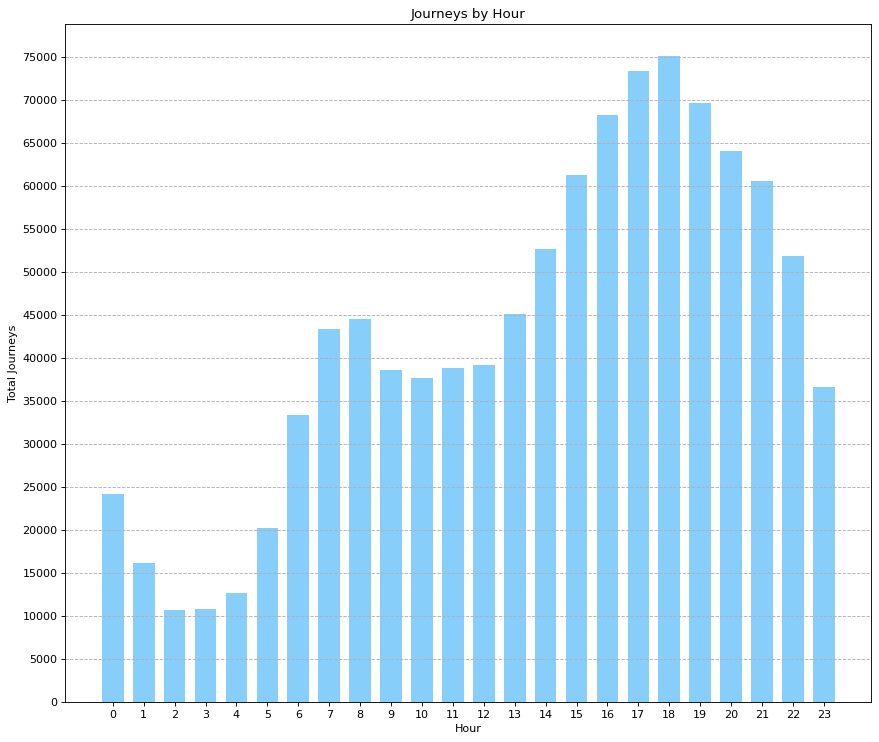

In [16]:
plt.figure(figsize=(13,11), dpi=80)
plt.subplot(1,1,1)
plt.grid(axis="y", linestyle='--')
width = 0.7

N = len(stats_h)
values = [d['count'] for d in stats_h]
index = np.arange(N)

p2 = plt.bar(index, values, width, color="#87CEFA")

plt.xlabel('Hour')
plt.ylabel('Total Journeys')
plt.title('Journeys by Hour')

plt.xticks(index)
plt.yticks(np.arange(0, 80000, 5000))

plt.show()

#网约车空间分布分析#

In [2]:
pip install basemap-1.3.3-cp311-cp311-win_amd64.whl

Defaulting to user installation because normal site-packages is not writeable
Processing d:\learning\bigdatasystem\uber_project\basemap-1.3.3-cp311-cp311-win_amd64.whl
  Using cached pyshp-2.1.3.tar.gz (219 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached matplotlib-3.5.3.tar.gz (35.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pyproj-3.3.1.tar.gz (219 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [2 lines of output]
      <string>:9: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      proj executable not found. Please set the PROJ_DIR variable. For more information see: https://pyproj4.github.io/pyproj/stable/installation.html
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [1]:
pip install pyproj

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib


from mpl_toolkits.basemap import Basemap
from matplotlib import cm

x_a = np.array([float(r['Lon']) for r in df.select(df['Lon']).collect()])
y_a = np.array([float(r['Lat']) for r in df.select(df['Lat']).collect()])

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'